# Processing images and text with VLMs 

This notebook demonstrates how to utilize the `HuggingFaceTB/SmolVLM-Instruct` 4bit-quantized model for various multimodal tasks such as:
- Visual Question Answering (VQA): Answering questions based on image content.
- Text Recognition (OCR): Extracting and interpreting text in images.
- Video Understanding: Describing videos through sequential frame analysis.

By structuring prompts effectively, you can leverage the model for many applications, such as scene understanding, document analysis, and dynamic visual reasoning.

In [1]:
# Install the requirements in Google Colab
# !pip install transformers datasets trl huggingface_hub bitsandbytes

# Authenticate to Hugging Face

import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"#,1"
from dotenv import load_dotenv
from huggingface_hub import login

load_dotenv()
hf_token = os.getenv("HF_TOKEN")
login(token=hf_token)
# from huggingface_hub import notebook_login
# notebook_login(hf_token)


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [2]:
import torch, PIL
from transformers import AutoProcessor, AutoModelForVision2Seq, BitsAndBytesConfig
from transformers.image_utils import load_image

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)

quantization_config = BitsAndBytesConfig(load_in_4bit=True)
model_name = "HuggingFaceTB/SmolVLM-Instruct"
model = AutoModelForVision2Seq.from_pretrained(
    model_name,
    quantization_config=quantization_config,
).to(device)
processor = AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-Instruct")

print(processor.image_processor.size)

`low_cpu_mem_usage` was None, now default to True since model is quantized.


{'longest_edge': 1536}


In [3]:
print(processor.image_processor)

Idefics3ImageProcessor {
  "do_convert_rgb": true,
  "do_image_splitting": true,
  "do_normalize": true,
  "do_pad": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "Idefics3ImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "max_image_size": {
    "longest_edge": 384
  },
  "processor_class": "Idefics3Processor",
  "resample": 1,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "longest_edge": 1536
  }
}



## Processing Images

Let's start with generating captions and answering questions about an image. We'll also explore processing multiple images.
### 1. Single Image Captioning

In [4]:
from IPython.display import Image, display

image_url1 = "https://cdn.pixabay.com/photo/2024/11/20/09/14/christmas-9210799_1280.jpg"
display(Image(url=image_url1))

image_url2 = "https://cdn.pixabay.com/photo/2024/11/23/08/18/christmas-9218404_1280.jpg"
display(Image(url=image_url2))

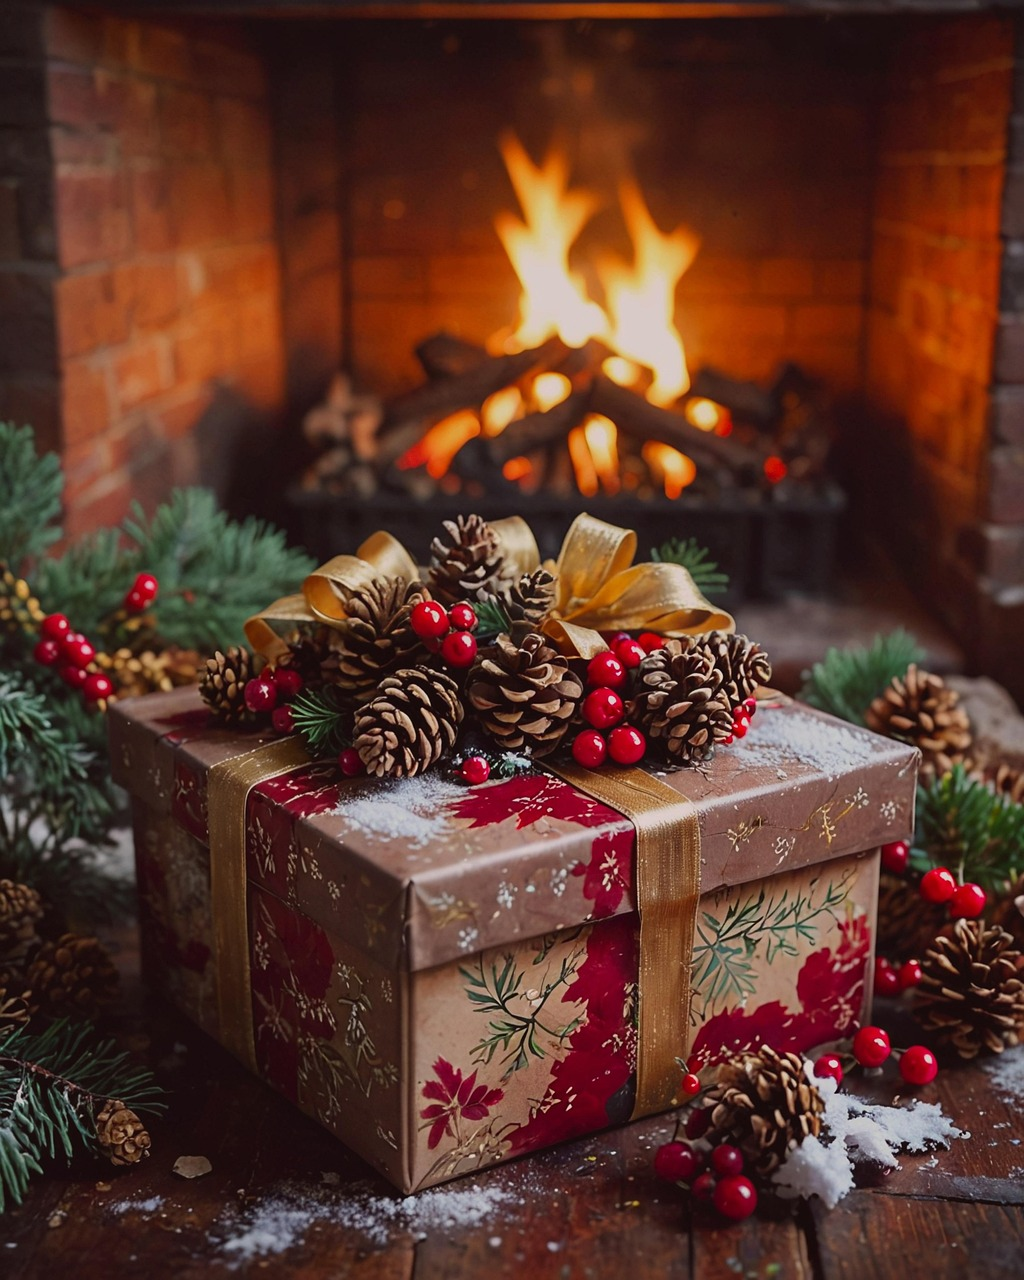

In [5]:
load_image(image_url2)

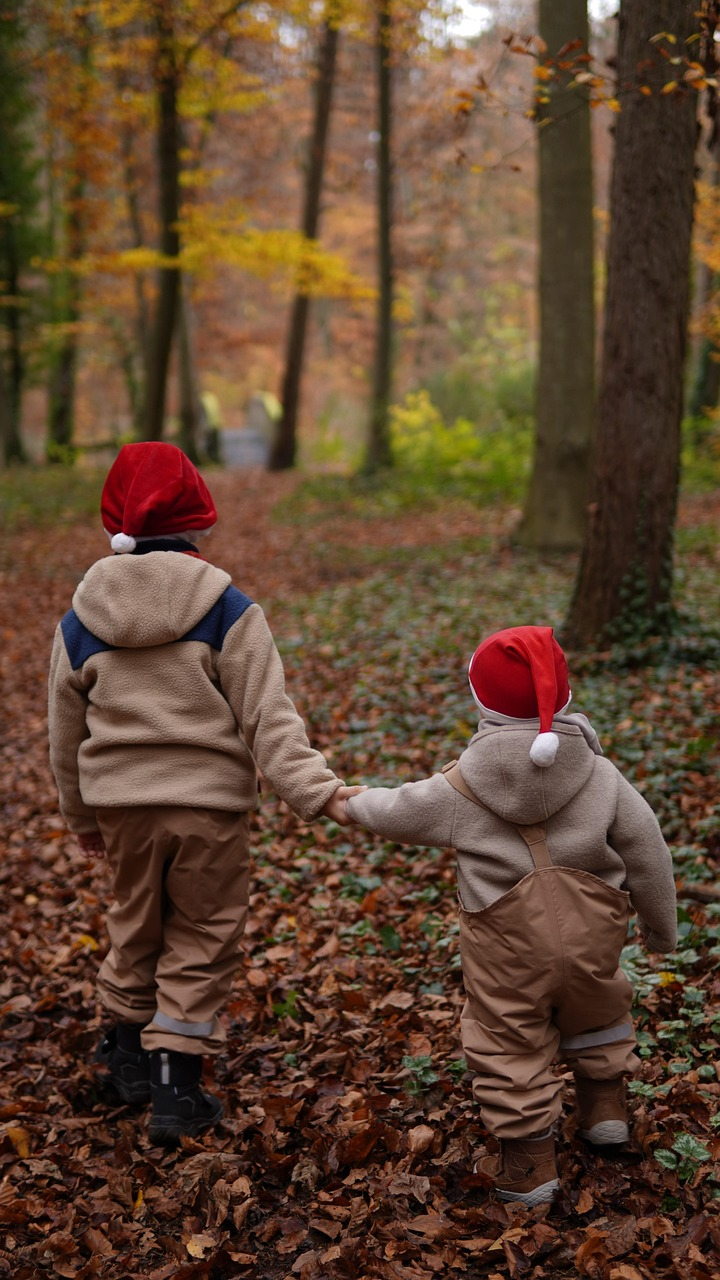

In [6]:
load_image(image_url1)

In [7]:
import inspect
inspect.getsourcelines(processor.apply_chat_template)
processor.apply_chat_template??

Signature:
processor.apply_chat_template(
    conversation: Union[List[Dict[str, str]], List[List[Dict[str, str]]]],
    chat_template: Optional[str] = None,
    **kwargs: *<class 'transformers.processing_utils.AllKwargsForChatTemplate'>,
) -> str
Source:   
    def apply_chat_template(
        self,
        conversation: Union[List[Dict[str, str]], List[List[Dict[str, str]]]],
        chat_template: Optional[str] = None,
        **kwargs: Unpack[AllKwargsForChatTemplate],
    ) -> str:
        """
        Similar to the `apply_chat_template` method on tokenizers, this method applies a Jinja template to input
        conversations to turn them into a single tokenizable string.

        The input is expected to be in the following format, where each message content is a list consisting of text and
        optionally image or video inputs. One can also provide an image, video, URL or local path which will be used to form
        `pixel_values` when `return_dict=True`. If not provided, on

In [8]:
# Load  one image
image1 = load_image(image_url1)

# Create input messages
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "Can you describe the image?"}
        ]
    },
]

# Prepare inputs
prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
prompt

'<|im_start|>User:<image>Can you describe the image?<end_of_utterance>\nAssistant:'

In [9]:
inputs = processor(text=prompt, images=[image1], return_tensors="pt")
inputs

{'pixel_values': tensor([[[[[-0.6941, -0.6941, -0.6941,  ..., -0.2392, -0.2706, -0.3020],
           [-0.6941, -0.7020, -0.7098,  ..., -0.2627, -0.3098, -0.3333],
           [-0.7020, -0.7098, -0.7098,  ..., -0.3098, -0.3725, -0.4118],
           ...,
           [-0.6784, -0.6784, -0.6784,  ...,  0.0902,  0.0824,  0.0745],
           [-0.6784, -0.6784, -0.6784,  ...,  0.0980,  0.0980,  0.0980],
           [-0.6706, -0.6706, -0.6706,  ...,  0.0980,  0.1137,  0.1137]],

          [[-0.6314, -0.6392, -0.6549,  ..., -0.4510, -0.4745, -0.4902],
           [-0.6471, -0.6471, -0.6627,  ..., -0.4667, -0.4980, -0.5137],
           [-0.6706, -0.6784, -0.6784,  ..., -0.4824, -0.5294, -0.5529],
           ...,
           [-0.6549, -0.6549, -0.6549,  ..., -0.1922, -0.1765, -0.1765],
           [-0.6471, -0.6471, -0.6471,  ..., -0.1843, -0.1765, -0.1686],
           [-0.6392, -0.6392, -0.6392,  ..., -0.1843, -0.1843, -0.1686]],

          [[-0.8196, -0.8196, -0.8353,  ..., -0.8275, -0.8431, -0.8745]

In [10]:
# Load  one image
image1 = load_image(image_url1)

# Create input messages
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "Can you describe the image?"}
        ]
    },
]

# Prepare inputs
prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(text=prompt, images=[image1], return_tensors="pt")
inputs = inputs.to(device)

# Generate outputs
generated_ids = model.generate(**inputs, max_new_tokens=500)
generated_texts = processor.batch_decode(
    generated_ids,
    skip_special_tokens=True,
)

print(generated_texts)


/data/pavan/opensource/smol-course/.venv/lib/python3.11/site-packages/bitsandbytes/nn/modules.py:451: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(


['User:<image>Can you describe the image?\nAssistant: The image is a scene of a forest.']


### 2. Comparing Multiple Images
The model can process and compare multiple images. Let's determine the common theme between two images.

In [11]:

# Load images
image2 = load_image(image_url2)

# Create input messages
messages = [
    # {
    #     "role": "user",
    #     "content": [
    #         {"type": "image"},
    #         {"type": "image"},
    #         {"type": "text", "text": "Can you describe the two images?"}
    #     ]
    # },
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "image"},
            {"type": "text", "text": "What event do they both represent?"}
        ]
    },
]

# Prepare inputs
prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(text=prompt, images=[image1, image2], return_tensors="pt")
inputs = inputs.to(device)

# Generate outputs
generated_ids = model.generate(**inputs, max_new_tokens=500)
generated_texts = processor.batch_decode(
    generated_ids,
    skip_special_tokens=True,
)

print(generated_texts)

['User:<image>What event do they both represent?\nAssistant: Christmas.']


### 🔠 Text Recognition (OCR)
VLM can also recognize and interpret text in images, making it suitable for tasks like document analysis.
You could try experimenting on images with denser text.

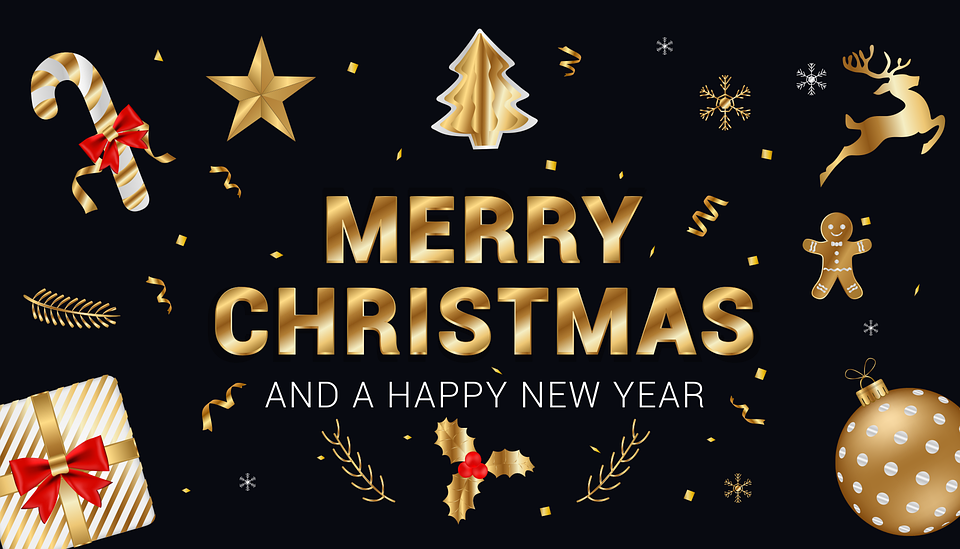

In [12]:
document_image_url = "https://cdn.pixabay.com/photo/2020/11/30/19/23/christmas-5792015_960_720.png"
load_image(document_image_url)

In [13]:
document_image_url = "https://cdn.pixabay.com/photo/2020/11/30/19/23/christmas-5792015_960_720.png"
display(Image(url=document_image_url))

# Load the document image
document_image = load_image(document_image_url)

# Create input message for analysis
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "What is written?"}
        ]
    }
]

# Prepare inputs
prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(text=prompt, images=[document_image], return_tensors="pt")
inputs = inputs.to(device)

# Generate outputs
generated_ids = model.generate(**inputs, max_new_tokens=500)
generated_texts = processor.batch_decode(
    generated_ids,
    skip_special_tokens=True,
)

print(generated_texts)

['User:<image>What is written?\nAssistant: MERRY CHRISTMAS AND A HAPPY NEW YEAR.']


## Processing videos

Visual-Language Models (VLMs) can process videos indirectly by extracting keyframes and reasoning over them in temporal order. While VLMs lack the temporal modeling capabilities of dedicated video models, they can still:
- Describe actions or events by analyzing sampled frames sequentially.
- Answer questions about videos based on representative keyframes.
- Summarize video content by combining textual descriptions of multiple frames.

Let experiment on an example:

<video width="640" height="360" controls>
  <source src="https://cdn.pixabay.com/video/2023/10/28/186794-879050032_large.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>

In [14]:
# !pip install opencv-python

In [15]:
from IPython.display import Video
import cv2
import numpy as np

def extract_frames(video_path, max_frames=50, target_size=None):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Could not open video: {video_path}")
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, total_frames - 1, max_frames, dtype=int)

    frames = []
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frame = PIL.Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            if target_size:
                frames.append(resize_and_crop(frame, target_size))
            else:
                frames.append(frame)
    cap.release()
    return frames

def resize_and_crop(image, target_size):
    width, height = image.size
    scale = target_size / min(width, height)
    image = image.resize((int(width * scale), int(height * scale)), PIL.Image.Resampling.LANCZOS)
    left = (image.width - target_size) // 2
    top = (image.height - target_size) // 2
    return image.crop((left, top, left + target_size, top + target_size))

# Video link
video_link = "https://cdn.pixabay.com/video/2023/10/28/186794-879050032_large.mp4"

In [18]:
frames = extract_frames(video_link, max_frames=15, target_size=384)

In [19]:
frames

[<PIL.Image.Image image mode=RGB size=384x384>,
 <PIL.Image.Image image mode=RGB size=384x384>,
 <PIL.Image.Image image mode=RGB size=384x384>,
 <PIL.Image.Image image mode=RGB size=384x384>,
 <PIL.Image.Image image mode=RGB size=384x384>,
 <PIL.Image.Image image mode=RGB size=384x384>,
 <PIL.Image.Image image mode=RGB size=384x384>,
 <PIL.Image.Image image mode=RGB size=384x384>,
 <PIL.Image.Image image mode=RGB size=384x384>,
 <PIL.Image.Image image mode=RGB size=384x384>,
 <PIL.Image.Image image mode=RGB size=384x384>,
 <PIL.Image.Image image mode=RGB size=384x384>,
 <PIL.Image.Image image mode=RGB size=384x384>,
 <PIL.Image.Image image mode=RGB size=384x384>,
 <PIL.Image.Image image mode=RGB size=384x384>]

In [20]:
question = "Describe what the woman is doing."

def generate_response(model, processor, frames, question):

    image_tokens = [{"type": "image"} for _ in frames]
    messages = [
        {
            "role": "user",
            "content": [{"type": "text", "text": "Following are the frames of a video in temporal order."}, *image_tokens, {"type": "text", "text": question}]
        }
    ]
    inputs = processor(
        text=processor.apply_chat_template(messages, add_generation_prompt=True),
        images=frames,
        return_tensors="pt"
    ).to(model.device)

    outputs = model.generate(
        **inputs, max_new_tokens=100, num_beams=5, temperature=0.7, do_sample=True, use_cache=True
    )
    return processor.decode(outputs[0], skip_special_tokens=True)


# Extract frames from the video
frames = extract_frames(video_link, max_frames=15, target_size=384)

processor.image_processor.size = (384, 384)
processor.image_processor.do_resize = False

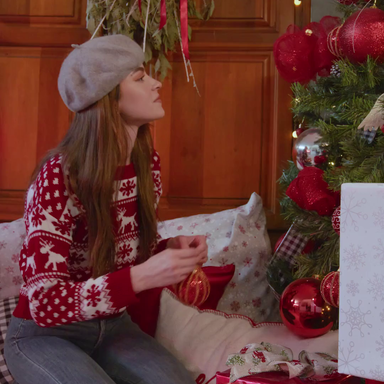

In [21]:
load_image(frames[0])

In [22]:
response = generate_response(model, processor, frames, question)

In [23]:
print("Response:", response)

Response: User: Following are the frames of a video in temporal order.<image>Describe what the woman is doing.
Assistant: The woman is hanging an ornament on a Christmas tree.


## 💐 You're Done!

This notebook demonstrated how to use a Visual-Language Model (VLM) such as formating prompts for multimodal tasks. By following the steps outlined here, you can experiment with VLMs and their applications.

### Next Steps to Explore:
- Experiment with more use cases of VLMs.
- Collaborate with a colleague by reviewing their pull requests (PRs).
- Contribute to improving this course material by opening an issue or submitting a PR to introduce new use cases, examples, or concepts.

Happy exploring! 🌟